# Hito 1

## 1. Preliminares

A continuación se detallan las características del problema a evaluar.

### 1.1 Problema (Análisis de sentimientos en Twitter)

El problema corresponde a uno de análisis de texto, donde queremos identificar el sentimiento asociado a un texto; el cual se refiere a un tweet.

Dado ello, es un problema de clasificación.

Objetivo: identificar si un tweet tiene polaridad positiva o negativa (sentimiento expresado).

* Variable objetivo: describe una emocion que resume el contenido de un tweet. Para conveniencia del trabajo, estas serán transformadas a emociones positivas o negativas de acuerdo a su morfología.

* Atributos: inicialmente existen textos que son tweets escritos en la plataforma de Twitter. Sin embargo, con objetivo de crear atributos para la predicción de emociones, transformaremos dichos textos en vectores de ocurrencia.

### 1.2 Modelos a implementar

Dado que el problema a estudiar es un problema de clasificación, proponemos la implementación de los siguientes modelos:

* Logistic Regression: método de clasificación que presente una fácil implementación y en general, un buen desempeño.

* KMeans: algoritmo que permite agrupar los datos en clusters, encontrando similitudes en los atributos.

* Linear Discriminant Analysis: algoritmo supervisado (tenemos conocimiento previo sobre la existencia de las clases y) y generativo (buscamos aprender sobre las clases a partir de los atributos X).

* Random Forest Classifier: dado que es un buen predictor para clasificadores al promediar el desempeño de un grupo de clasificadores, e implementa un proceso de validación cruzada con un sample menor al número total de atributos disponibles; permitiendo evaluar el desempeño "out-of-bag" en cada iteración.

* Gradient Boosting: algoritmo que ajusta los pesos asociados a cada atributo en cada iteración en base al error residual que esta teniendo el modelo. A medida que aumentan las iteraciones, la función objetivo acoplada en los residuos tiende a situarse cercano a cero.

Dado los algoritmos presentados anteriormente, se definen los siguientes parámetros de grilla:

*  Logistic Regression: 

    params = {
        'C' = np.logspace(-4, 4, 50),
        'penalty': ['l1', 'l2']}

* KMeans:

    params = {
            'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
            }

* Linear Discriminant Analysis:

    params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

* Random Forest Classifier:

    params = {
        n_estimators = range(20, 1000, 25),
        'max_features': [None, 'log2', 'sqrt']}

* Gradient Boosting:

    param_grid = {'n_estimators': [100, 500, 1000],
                'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
                'subsample': np.linspace(0.1, 1.0, 5, endpoint=True, dtype=float)}

### 1.3 Métricas y estrategia de división de muestras

Las métricas a utilizar para este problema de clasificación serán:

* accuracy_score: define el ratio de asignaciones correctas

* roc_auc_score: curva que permite comparar la clasificación de nuestro modelo con un clasificador aleatorio

* confusion_matrix: matriz que nos permite identificar tanto las asignaciones correctas como las que no; separadas por clase

* classification_report: reporte que nos brinda el Precision (porcentaje de clasificaciones correctas entre las asignadas), Recall (porcentaje de una clase que somos capaces de identficar correctamente), F1-score (ponderacion entre Precission y Recall) y Accuracy (igual a accuracy_score) de nuestro modelo

Por otro lado, para dividir nuestro conjunto de datos utilizaremos el módulo "train_test_split()" de scikit-learn. Utilizaremos un 33% del set de datos como conjunto validador y además utilizaremos una semilla pseudo-aleatoria para poder replicar los resultados.

### 1.4 Procesamiento tentativo

* Se eliminarán las filas que posean ya sea el tweet o la emoción incompleta, ya que pierde las características mínimas necesarias para participar del proceso predictivo

* Se aplicarán técnicas de procesamiento de lenguaje natural (NLP) para hacer una limpieza inicial de los tweets considerando: normalización de tweets a minúscula, eliminación de caracteres especiales, lematización, entre otros

* Se utilizará el módulo de scikit-learn TfidfVectorizer o CountVectorizer para transformar los tweets en vectores numéricos

* Las etiquetas neutras serán clasificadas como negativas el 51% de las veces, y positivas el 49%. Esto dado las probabilidades proporcionales iniciales de dichas clases y además, dado que la emoción neutra no aporta características relevantes al modelo

## 2. Aspectos Computacionales

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

from static import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gonzalooportus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gonzalooportus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gonzalooportus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gonzalooportus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Feature Engineering

In [2]:
# lectura de datos
data = pd.read_csv('training_tweets.csv').drop('Unnamed: 0', axis=1)

### 3.1 limpieza de tweets

In [3]:
# aplicando normalización y lemmatizacion a los tweets
df_clean = nlp_cleaning(data)

In [4]:
df = df_clean.loc[:, ['content_clean', 'sentiment']]
df.rename(columns={'content_clean': 'content'}, inplace=True)

### 3.2 Transformando emociones

In [5]:
emotion_dict = {
    'worry': 'negativa',
    'happiness': 'positiva',
    'sadness': 'negativa',
    'love': 'positiva',
    'surprise': 'positiva',
    'fun': 'positiva',
    'relief': 'positiva',
    'hate': 'negativa',
    'empty': 'negativa',
    'enthusiasm': 'positiva',
    'boredom': 'negativa',
    'anger': 'negativa'
}

In [6]:
# reemplazando emociones
df['sentiment'] = df['sentiment'].replace(emotion_dict)

In [7]:
0.38 + 0.4

0.78

In [8]:
# probabilidad inicial de emociones
df['sentiment'].value_counts('%')

negativa    0.400733
positiva    0.384233
neutral     0.215033
Name: sentiment, dtype: float64

In [9]:
# reemplazando emocion neutral
binary = ['negativa', 'positiva']
df['sentiment'] = [i.replace('neutral', np.random.choice(binary, 1, p=[0.51, 0.49])[0]) for i in df['sentiment']]

### 3.3 Transformamos el conjunto de datos en una matriz que represente la ocurrencia de cada palabra

In [10]:
# Create a Vectorizer Object
vectorizer = CountVectorizer()

In [11]:
# ajustamos el modelo con los
X = vectorizer.fit_transform(df['content'])

In [12]:
df_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [13]:
# reducimos el espacio eliminando palabras insignificantes
df_count = df_count.iloc[:, 899:-5]

In [14]:
# juntamos los conjuntos de datos
x_attr = df_count.copy()

# 4. Análisis Exploratorio

A continuación indagamos sobre la estructura inicial de nuestro conjunto de datos en cuanto a contenido.

### 4.1 Distribución de clases en vector objetivo

<AxesSubplot:xlabel='sentiment', ylabel='count'>

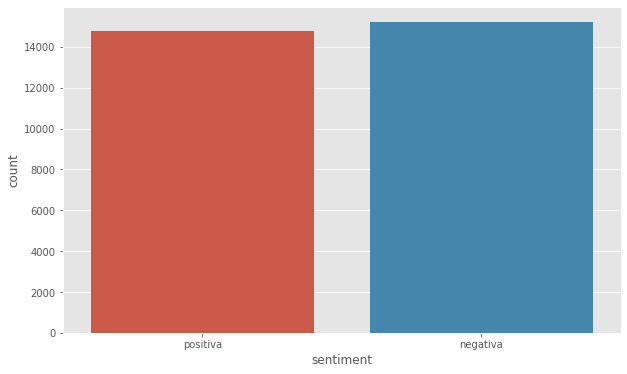

In [15]:
sns.countplot(x=df['sentiment'])

A partir del gráfico anterior identificamos que las clases de emociones: positiva, y negativa; se encuentran balanceadas.

### 4.2 Palabras más comunes

In [16]:
# dataframe con palabras y el número de veces que están presente en tweets
words = vectorizer.get_feature_names()
words_freq = X.toarray().sum(axis=0)
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

In [17]:
# obtenemos las 5000 palabras más comunes
words_freq_df.columns= ['word', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False).iloc[0:5000, :].reset_index(drop=True)

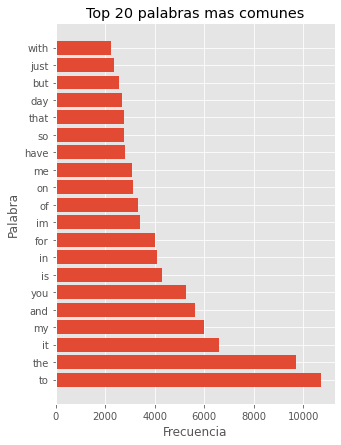

In [18]:
# visualizamos la distribucion de las 20 palabras con mayor uso
plt.figure(figsize=(5, 7))
plt.barh(words_freq_df['word'][:20], words_freq_df['freq'][:20])
plt.title('Top 20 palabras mas comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()